In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway

In [ ]:
# Step 2: Load the dataset
df = pd.read_csv('data.csv')

In [ ]:
# Step 3: Rename columns for easier analysis
df = df.rename(columns={
    'Timestamp': 'timestamp',
    'What is your birth year?': 'birth_year',
    'Which faculty are you enrolled in ?': 'faculty',
    'What grade are you in?': 'grade',
    'Would you like to specify your gender?': 'gender',
    'Which options describe your enrollment history? You can select all that apply.': 'enrollment_history',
    'Which career fields do you want to be in? (You can choose multiple.)': 'career_fields',
    'Select maximum 4 that you think affected your career choices the most.': 'career_influences',
    'How much pressure you felt from your peers and family during making a decision about your career?': 'external_pressure',
    'How important is personal fulfillment (doing what you love) in your career choice? ': 'personal_fulfillment',
    'Which one/ones most influenced your career decisions?': 'career_decision_influences',
    'Which one/ones represent what “career success” means to you?': 'career_success_meaning',
    'How confident are you in understanding which career paths align with your skills and interests?': 'career_confidence',
    'How likely are you to change your career if you find that it does not align with your values, abilities, personal fulfillment, or the job market?': 'career_change_likelihood',
    'What is your CGPA? (If it is available.)': 'cgpa'
})

In [ ]:
# Display the first few rows of the dataset
print(df.head())

# Get basic information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Get summary statistics for numerical columns
print(df.describe())

             timestamp  birth_year                       faculty grade  \
0  11/29/2024 19:46:04        2004  Faculty of Arts and Sciences   1st   
1  11/29/2024 19:50:21        2003        Faculty of Engineering   3rd   
2   11/30/2024 0:15:13        2001          Faculty of Education   4th   
3   11/30/2024 0:24:26        1998        Faculty of Engineering   2nd   
4   11/30/2024 0:31:43        2005  Faculty of Arts and Sciences   1st   

   gender                                 enrollment_history  \
0  Female                 I took a gap year (Mezuna kaldım.)   
1  Female  I got placed on my first attempt with the univ...   
2  Female                 I took a gap year (Mezuna kaldım.)   
3    Male     Undergraduate transfer (Yatay geçişle geldim.)   
4    Male                 I took a gap year (Mezuna kaldım.)   

                                       career_fields  \
0  Engineering & Technology, Self-Employed & Free...   
1  Business & Management, Engineering & Technolog...   
2 

Weighted Mean of Career Influences by Faculty:
career_influences                                Family influence  \
faculty                                                             
Faculty of Architecture                                  0.195652   
Faculty of Arts and Sciences                             0.111111   
Faculty of Economic and Administrative Sciences          0.241379   
Faculty of Education                                     0.120000   
Faculty of Engineering                                   0.114286   

career_influences                                Financial stability  \
faculty                                                                
Faculty of Architecture                                     0.304348   
Faculty of Arts and Sciences                                0.333333   
Faculty of Economic and Administrative Sciences             0.551724   
Faculty of Education                                        0.240000   
Faculty of Engineering               

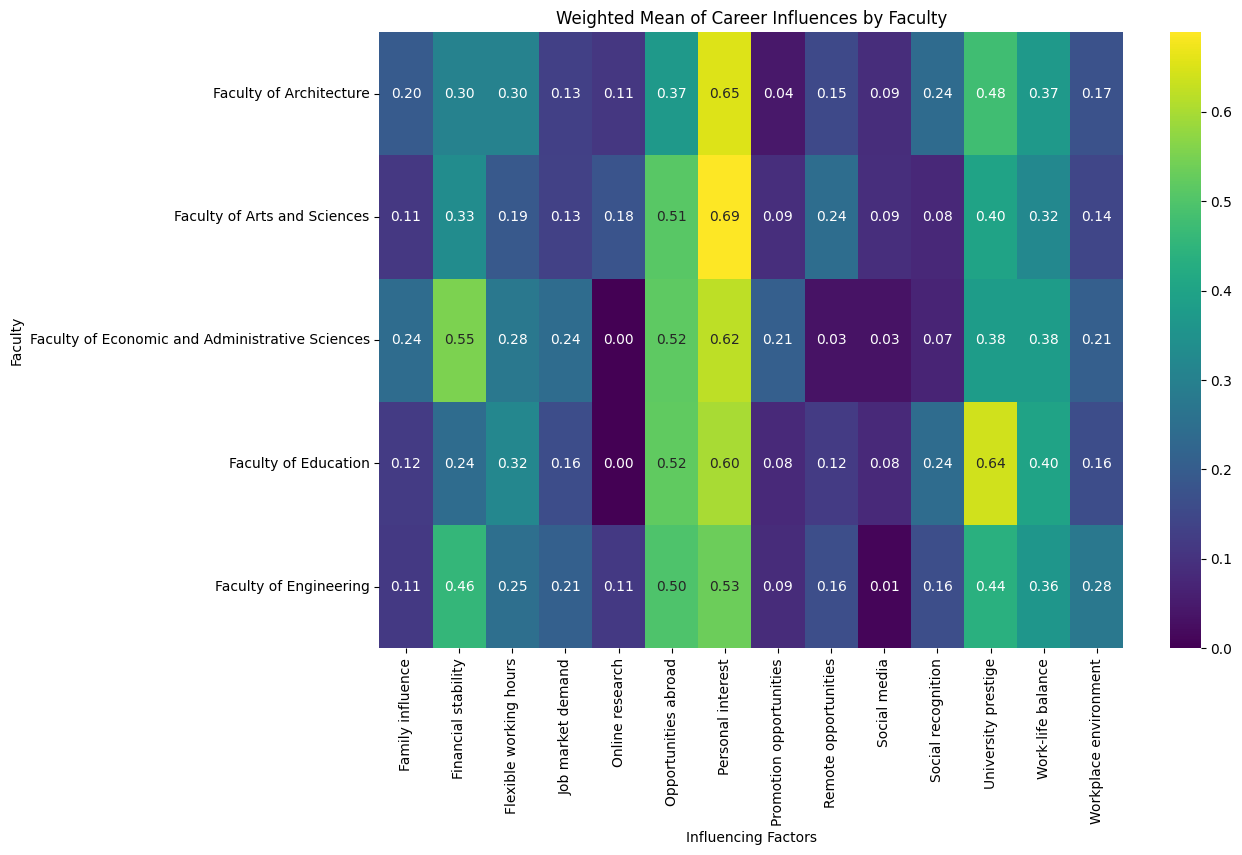

In [ ]:
# Split the 'career_influences' column into individual factors
df['career_influences'] = df['career_influences'].str.split(', ')

# Explode the list of factors into separate rows
exploded_influences = df.explode('career_influences')

# Group by faculty and calculate the weighted mean of each factor
faculty_counts = df['faculty'].value_counts().reset_index()
faculty_counts.columns = ['faculty', 'total_students']

# Merge with faculty counts
weighted_influences = exploded_influences.groupby(['faculty', 'career_influences']).size().reset_index(name='count')
weighted_influences = pd.merge(weighted_influences, faculty_counts, on='faculty')

# Calculate the weighted mean for each factor
weighted_influences['weighted_mean'] = weighted_influences['count'] / weighted_influences['total_students']

# Pivot the table for better visualization
weighted_influences_pivot = weighted_influences.pivot(index='faculty', columns='career_influences', values='weighted_mean').fillna(0)

print("Weighted Mean of Career Influences by Faculty:")
print(weighted_influences_pivot)

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(weighted_influences_pivot, annot=True, cmap='viridis', fmt='.2f')
plt.title('Weighted Mean of Career Influences by Faculty')
plt.xlabel('Influencing Factors')
plt.ylabel('Faculty')
plt.show()

In [ ]:
from itertools import combinations
from scipy.stats import chi2_contingency

# Get unique faculties
faculties = exploded_influences['faculty'].unique()

# Perform pairwise Chi-Square tests for each faculty combination
faculty_pairs = list(combinations(faculties, 2))
significant_pairs = []

for pair in faculty_pairs:
    faculty1, faculty2 = pair
    # Filter data for the current pair of faculties
    pair_data = exploded_influences[exploded_influences['faculty'].isin(pair)]

    # Create a contingency table for the current pair
    contingency_table_pair = pd.crosstab(pair_data['faculty'], pair_data['career_influences'])

    # Perform Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table_pair)

    # Check if the result is significant
    if p_value < 0.05:
        significant_pairs.append((faculty1, faculty2, p_value))

# Output the significant pairs
if significant_pairs:
    print("Significant differences found between the following faculty pairs:")
    for pair in significant_pairs:
        print(f"{pair[0]} vs {pair[1]} (p-value: {pair[2]:.4f})")
else:
    print("No significant differences found between any faculty pairs.")

Significant differences found between the following faculty pairs:
Faculty of Arts and Sciences vs Faculty of Engineering (p-value: 0.0459)


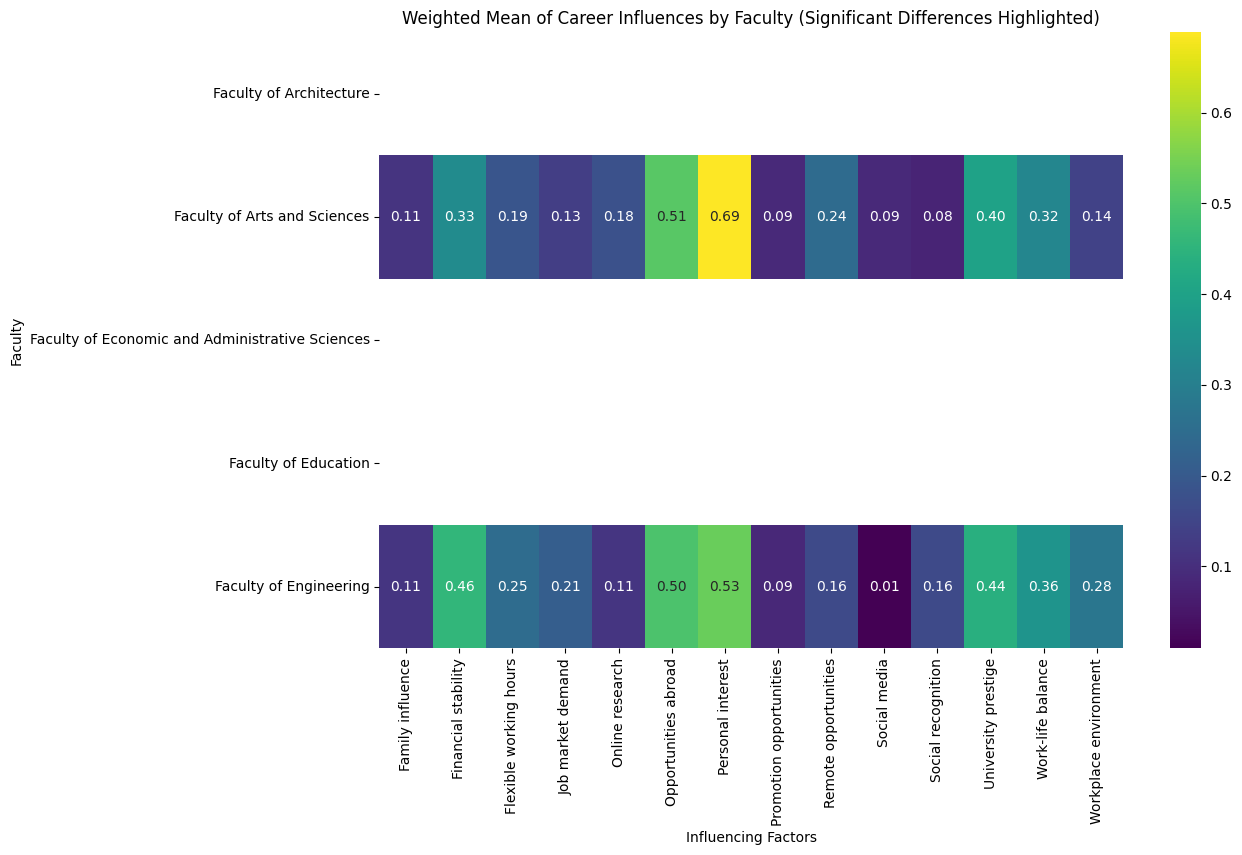

In [ ]:
import numpy as np

# Create a mask to highlight significant faculty pairs
significant_mask = np.zeros_like(weighted_influences_pivot, dtype=bool)

# Mark cells for significant faculty pairs
for pair in significant_pairs:
    faculty1, faculty2, _ = pair
    if faculty1 in weighted_influences_pivot.index and faculty2 in weighted_influences_pivot.index:
        significant_mask[weighted_influences_pivot.index.get_loc(faculty1), :] = True
        significant_mask[weighted_influences_pivot.index.get_loc(faculty2), :] = True

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(weighted_influences_pivot, annot=True, cmap='viridis', fmt='.2f', mask=~significant_mask)
plt.title('Weighted Mean of Career Influences by Faculty (Significant Differences Highlighted)')
plt.xlabel('Influencing Factors')
plt.ylabel('Faculty')
plt.show()

In [ ]:
# Create binary columns for each influencing factor
df['Personal interest'] = df['career_influences'].apply(lambda x: 1 if 'Personal interest' in x else 0)
df['Financial stability'] = df['career_influences'].apply(lambda x: 1 if 'Financial stability' in x else 0)

# Filter data for Engineering and Arts & Sciences
engineering_data = df[df['faculty'] == 'Faculty of Engineering']
arts_sciences_data = df[df['faculty'] == 'Faculty of Arts and Sciences']

In [ ]:
from scipy.stats import chi2_contingency

# Perform Chi-Square Test for Personal interest
contingency_table_personal = pd.crosstab(df['faculty'], df['Personal interest'])
chi2_personal, p_personal, _, _ = chi2_contingency(contingency_table_personal)

# Perform Chi-Square Test for Financial stability
contingency_table_financial = pd.crosstab(df['faculty'], df['Financial stability'])
chi2_financial, p_financial, _, _ = chi2_contingency(contingency_table_financial)

# Output the results
print("Chi-Square Test for Personal interest:")
print(f"Chi-Square Statistic: {chi2_personal}")
print(f"P-value: {p_personal}")
if p_personal < 0.05:
    print("There is a statistically significant difference between Engineering and Arts & Sciences for Personal interest.")
else:
    print("There is no statistically significant difference between Engineering and Arts & Sciences for Personal interest.")
print("---")

print("Chi-Square Test for Financial stability:")
print(f"Chi-Square Statistic: {chi2_financial}")
print(f"P-value: {p_financial}")
if p_financial < 0.05:
    print("There is a statistically significant difference between Engineering and Arts & Sciences for Financial stability.")
else:
    print("There is no statistically significant difference between Engineering and Arts & Sciences for Financial stability.")

Chi-Square Test for Personal interest:
Chi-Square Statistic: 5.319059074062208
P-value: 0.25609803984418356
There is no statistically significant difference between Engineering and Arts & Sciences for Personal interest.
---
Chi-Square Test for Financial stability:
Chi-Square Statistic: 10.194145896353533
P-value: 0.037281273224847235
There is a statistically significant difference between Engineering and Arts & Sciences for Financial stability.


Weighted Mean of Career Success Definitions by Faculty:
career_success_meaning                           Achieving recognition in the field  \
faculty                                                                               
Faculty of Architecture                                                    0.413043   
Faculty of Arts and Sciences                                               0.422222   
Faculty of Economic and Administrative Sciences                            0.379310   
Faculty of Education                                                       0.400000   
Faculty of Engineering                                                     0.457143   

career_success_meaning                           High income  Job stability  \
faculty                                                                       
Faculty of Architecture                             0.586957       0.282609   
Faculty of Arts and Sciences                        0.411111       0.255556   
Faculty of Economi

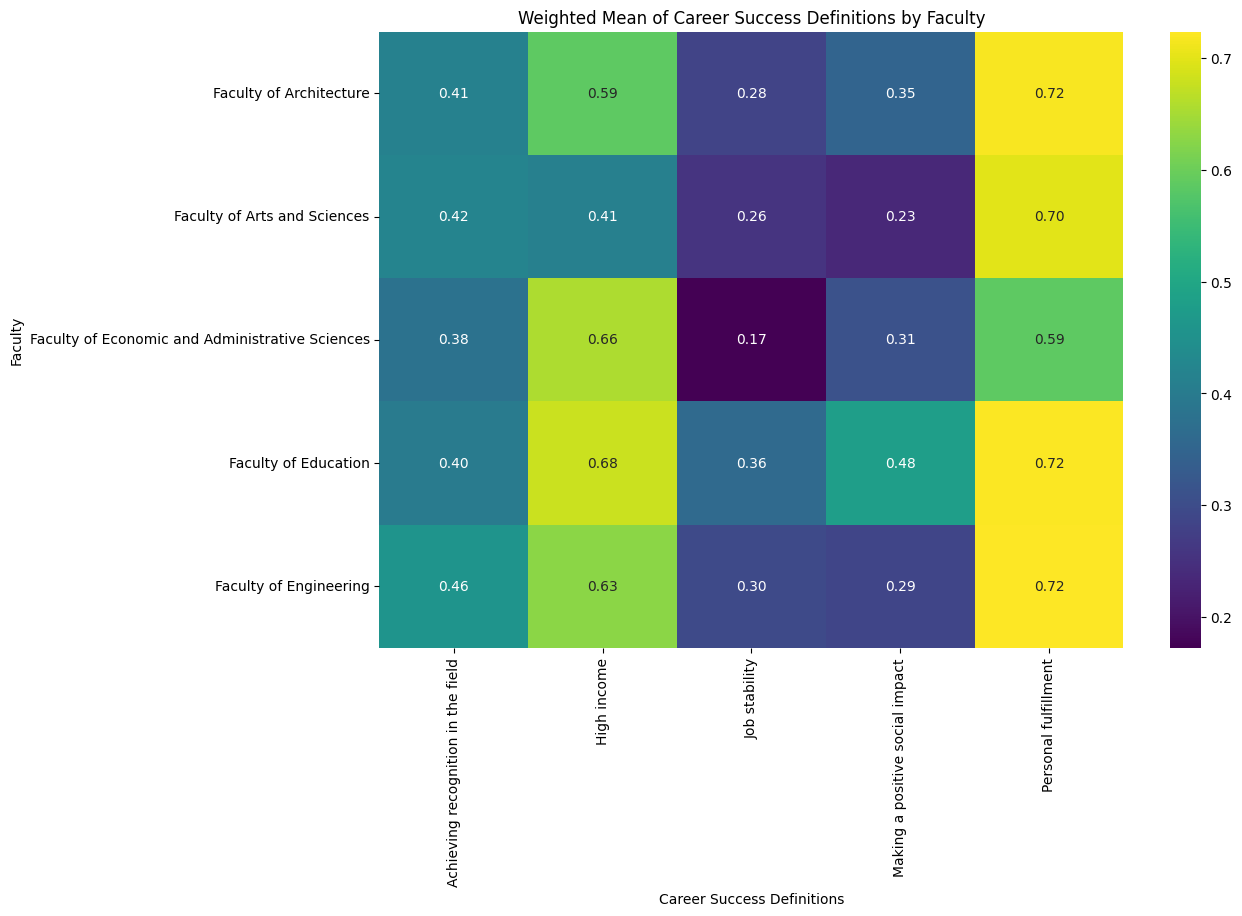

In [ ]:
# Split the 'career_success_meaning' column into individual definitions
df['career_success_meaning'] = df['career_success_meaning'].str.split(', ')

# Explode the list of definitions into separate rows
exploded_success = df.explode('career_success_meaning')

# Group by faculty and calculate the weighted mean of each definition
weighted_success = exploded_success.groupby(['faculty', 'career_success_meaning']).size().reset_index(name='count')
weighted_success = pd.merge(weighted_success, faculty_counts, on='faculty')

# Calculate the weighted mean for each definition
weighted_success['weighted_mean'] = weighted_success['count'] / weighted_success['total_students']

# Pivot the table for better visualization
weighted_success_pivot = weighted_success.pivot(index='faculty', columns='career_success_meaning', values='weighted_mean').fillna(0)

print("Weighted Mean of Career Success Definitions by Faculty:")
print(weighted_success_pivot)

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(weighted_success_pivot, annot=True, cmap='viridis', fmt='.2f')
plt.title('Weighted Mean of Career Success Definitions by Faculty')
plt.xlabel('Career Success Definitions')
plt.ylabel('Faculty')
plt.show()

In [ ]:
from scipy.stats import f_oneway

# Prepare data for ANOVA
faculties = weighted_success['faculty'].unique()
anova_data = [weighted_success[weighted_success['faculty'] == faculty]['weighted_mean'] for faculty in faculties]

# Perform ANOVA
f_statistic, p_value = f_oneway(*anova_data)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in career success definitions across faculties.")
else:
    print("There is no statistically significant difference in career success definitions across faculties.")

F-statistic: 0.3525605592268482
P-value: 0.8391620318516531
There is no statistically significant difference in career success definitions across faculties.


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = weighted_success_pivot.fillna(0)

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

# Interpret the results
if p < 0.05:
    print("There is a statistically significant association between faculty and career success definitions.")
else:
    print("There is no statistically significant association between faculty and career success definitions.")

Chi-Square Statistic: 0.17565496402271483
P-value: 0.9999999999999187
There is no statistically significant association between faculty and career success definitions.


In [ ]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis Test
h_statistic, p_value = kruskal(*anova_data)

print(f"H-statistic: {h_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in career success definitions across faculties.")
else:
    print("There is no statistically significant difference in career success definitions across faculties.")

H-statistic: 1.9421538461538432
P-value: 0.7463975825765828
There is no statistically significant difference in career success definitions across faculties.


In [ ]:
# Test 'personal_fulfillment' and 'external_pressure' across faculties
anova_personal_fulfillment_by_faculty = f_oneway(
    *[group["personal_fulfillment"].dropna() for _, group in df.groupby('faculty')]
)

anova_external_pressure_by_faculty = f_oneway(
    *[group["external_pressure"].dropna() for _, group in df.groupby('faculty')]
)

# Test 'personal_fulfillment' and 'external_pressure' across gender groups
anova_personal_fulfillment_by_gender = f_oneway(
    *[group["personal_fulfillment"].dropna() for _, group in df.groupby('gender')]
)

anova_external_pressure_by_gender = f_oneway(
    *[group["external_pressure"].dropna() for _, group in df.groupby('gender')]
)

# Collect all ANOVA results for these variables
anova_results_personal_pressure = {
    "personal_fulfillment_by_faculty": anova_personal_fulfillment_by_faculty,
    "external_pressure_by_faculty": anova_external_pressure_by_faculty,
    "personal_fulfillment_by_gender": anova_personal_fulfillment_by_gender,
    "external_pressure_by_gender": anova_external_pressure_by_gender,
}

anova_results_personal_pressure
#BY GENDER EXTERNALL PRESSURE SIGNIFICANT


{'personal_fulfillment_by_faculty': F_onewayResult(statistic=0.7246429819854483, pvalue=0.5757006755066925),
 'external_pressure_by_faculty': F_onewayResult(statistic=1.3161382819641299, pvalue=0.2639976829259581),
 'personal_fulfillment_by_gender': F_onewayResult(statistic=0.06096842060931159, pvalue=0.9408649246331074),
 'external_pressure_by_gender': F_onewayResult(statistic=5.874490714238597, pvalue=0.003153051696412242)}

In [ ]:
# Test 'career_confidence' and 'career_change_likelihood' across faculties
anova_career_confidence_by_faculty = f_oneway(
    *[group["career_confidence"].dropna() for _, group in df.groupby('faculty')]
)

anova_career_change_likelihood_by_faculty = f_oneway(
    *[group["career_change_likelihood"].dropna() for _, group in df.groupby('faculty')]
)

# Test 'career_confidence' and 'career_change_likelihood' across gender groups
anova_career_confidence_by_gender = f_oneway(
    *[group["career_confidence"].dropna() for _, group in df.groupby('gender')]
)

anova_career_change_likelihood_by_gender = f_oneway(
    *[group["career_change_likelihood"].dropna() for _, group in df.groupby('gender')]
)

# Collect all ANOVA results for these variables
anova_results_career = {
    "career_confidence_by_faculty": anova_career_confidence_by_faculty,
    "career_change_likelihood_by_faculty": anova_career_change_likelihood_by_faculty,
    "career_confidence_by_gender": anova_career_confidence_by_gender,
    "career_change_likelihood_by_gender": anova_career_change_likelihood_by_gender,
}

anova_results_career

{'career_confidence_by_faculty': F_onewayResult(statistic=1.5143549513876347, pvalue=0.19798435768602932),
 'career_change_likelihood_by_faculty': F_onewayResult(statistic=0.33143673599765033, pvalue=0.8567308262627968),
 'career_confidence_by_gender': F_onewayResult(statistic=10.083750912397099, pvalue=5.824970555569287e-05),
 'career_change_likelihood_by_gender': F_onewayResult(statistic=0.12545485488523667, pvalue=0.8821431052120035)}

<ipython-input-60-5fc4b615a88f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='gender', y='career_confidence', palette='coolwarm', inner='quartile')


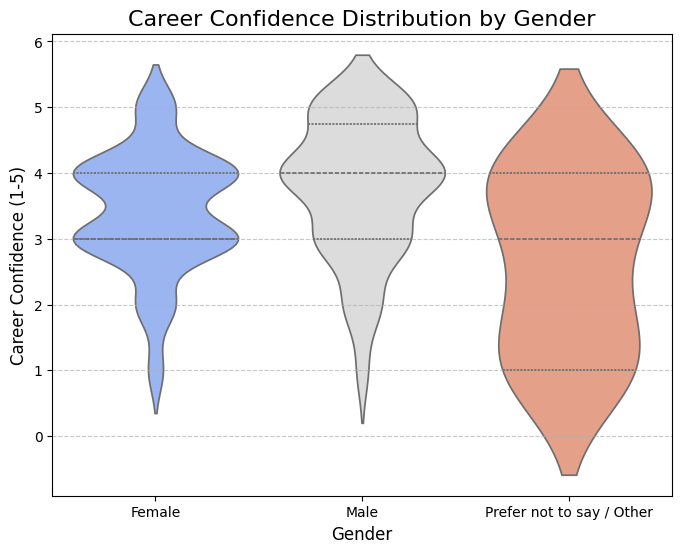

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,172.0,3.412791,0.910279,1.0,3.0,3.0,4.00,5.0
Male,110.0,3.763636,1.022026,1.0,3.0,4.0,4.75,5.0
Prefer not to say / Other,13.0,2.615385,1.325296,1.0,1.0,3.0,4.00,4.0


In [ ]:
# Display summary statistics for career confidence by gender
gender_summary = df.groupby('gender')['career_confidence'].describe()

# Visualize the distribution with a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='gender', y='career_confidence', palette='coolwarm', inner='quartile')
plt.title('Career Confidence Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Career Confidence (1-5)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display summary statistics for reference
gender_summary


<ipython-input-61-e675e49da870>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='gender', y='external_pressure', palette='coolwarm', inner='quartile')


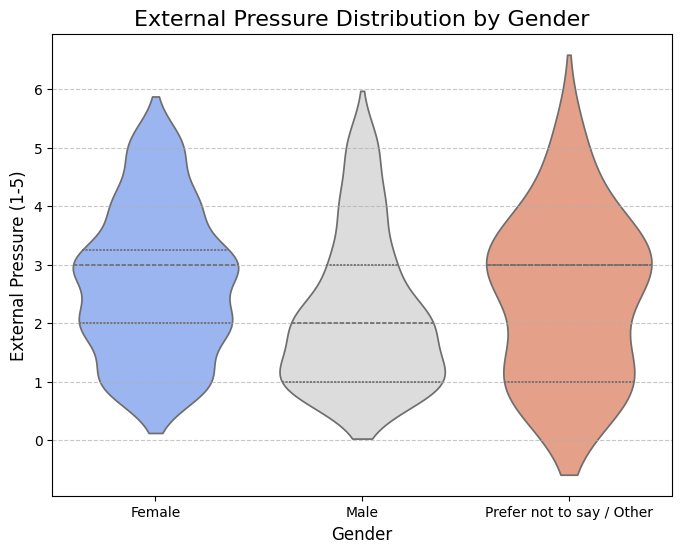

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,172.0,2.691860,1.229911,1.0,2.0,3.0,3.25,5.0
Male,110.0,2.172727,1.247817,1.0,1.0,2.0,3.00,5.0
Prefer not to say / Other,13.0,2.461538,1.330124,1.0,1.0,3.0,3.00,5.0


In [ ]:
# Visualize the distribution of external pressure by gender using a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='gender', y='external_pressure', palette='coolwarm', inner='quartile')
plt.title('External Pressure Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('External Pressure (1-5)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display summary statistics for external pressure by gender
external_pressure_summary = df.groupby('gender')['external_pressure'].describe()
external_pressure_summary


Pearson Correlation Matrix:
                          external_pressure  personal_fulfillment  \
external_pressure                  1.000000             -0.017176   
personal_fulfillment              -0.017176              1.000000   
career_confidence                 -0.078569              0.222083   
career_change_likelihood           0.045942              0.208434   

                          career_confidence  career_change_likelihood  
external_pressure                 -0.078569                  0.045942  
personal_fulfillment               0.222083                  0.208434  
career_confidence                  1.000000                 -0.028459  
career_change_likelihood          -0.028459                  1.000000  


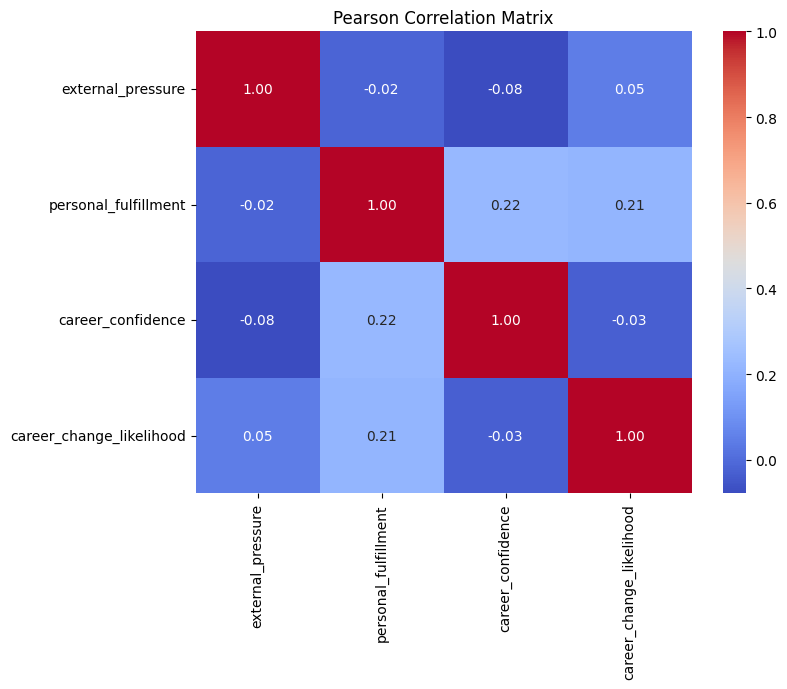

Spearman Correlation Matrix:
                          external_pressure  personal_fulfillment  \
external_pressure                  1.000000             -0.046915   
personal_fulfillment              -0.046915              1.000000   
career_confidence                 -0.118710              0.230703   
career_change_likelihood           0.042910              0.221141   

                          career_confidence  career_change_likelihood  
external_pressure                 -0.118710                  0.042910  
personal_fulfillment               0.230703                  0.221141  
career_confidence                  1.000000                 -0.007026  
career_change_likelihood          -0.007026                  1.000000  


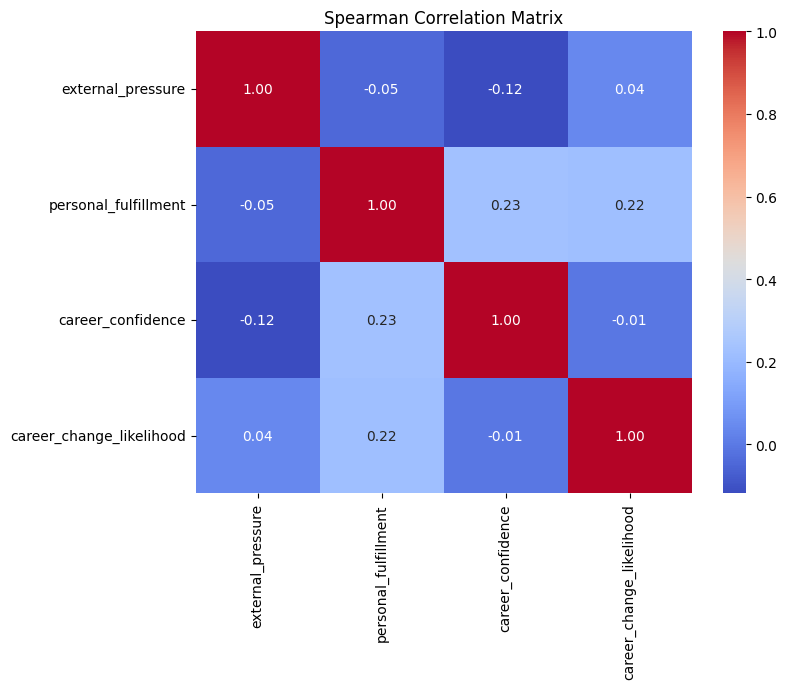

In [ ]:
numeric_columns = [
    "external_pressure",
    "personal_fulfillment",
    "career_confidence",
    "career_change_likelihood"
]

# Subset the dataset for numeric analysis
numeric_data = df[numeric_columns]

# Compute the Pearson correlation matrix
pearson_correlation_matrix = numeric_data.corr(method="pearson")

# Compute the Spearman correlation matrix
spearman_correlation_matrix = numeric_data.corr(method="spearman")

# Display and plot the Pearson correlation matrix
print("Pearson Correlation Matrix:")
print(pearson_correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(pearson_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Pearson Correlation Matrix")
plt.show()

# Display and plot the Spearman correlation matrix
print("Spearman Correlation Matrix:")
print(spearman_correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Spearman Correlation Matrix")
plt.show()



Insights:
Personal Fulfillment vs. Career Confidence:

A moderate positive correlation (~0.22 for both Pearson and Spearman) suggests that individuals valuing personal fulfillment are more confident about their career alignment.
Personal Fulfillment vs. Career Change Likelihood:

Positive correlation (~0.21 for Pearson, ~0.22 for Spearman) indicates that individuals prioritizing personal fulfillment are more likely to change their careers if misaligned.
External Pressure:

Weak correlations with other variables suggest external pressure has minimal influence on personal fulfillment, confidence, or likelihood of career change.
Career Confidence vs. Career Change Likelihood:

Almost no correlation suggests confidence in career alignment doesn't predict the likelihood of a career change.

Weighted Mean of Career Decision Influences by Faculty:
career_decision_influences                       Career fairs  Counselors  \
faculty                                                                     
Faculty of Architecture                              0.108696    0.043478   
Faculty of Arts and Sciences                         0.100000    0.044444   
Faculty of Economic and Administrative Sciences      0.068966    0.034483   
Faculty of Education                                 0.080000    0.040000   
Faculty of Engineering                               0.161905    0.095238   

career_decision_influences                       Internship  Projects  \
faculty                                                                 
Faculty of Architecture                            0.347826  0.434783   
Faculty of Arts and Sciences                       0.200000  0.311111   
Faculty of Economic and Administrative Sciences    0.344828  0.137931   
Faculty of Education                   

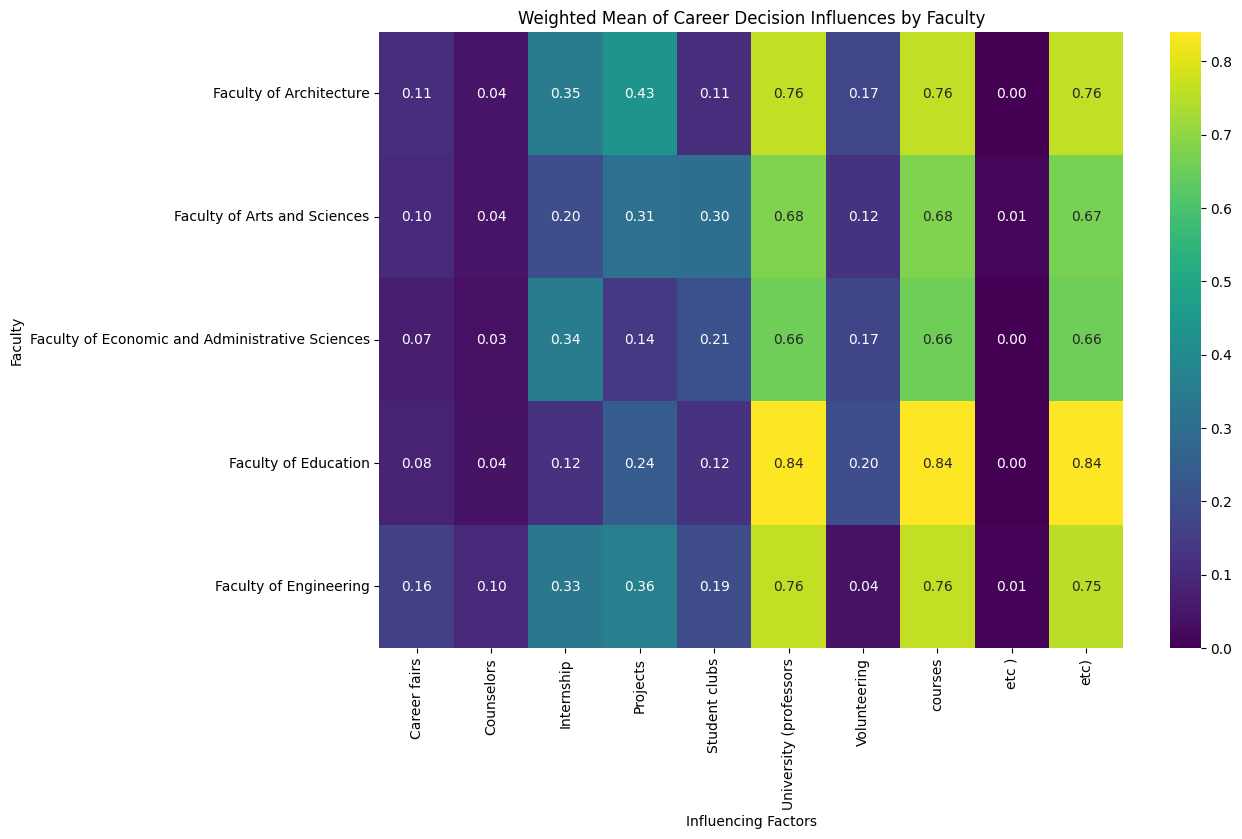

In [ ]:
# Split the 'career_influences' column into individual factors
df['career_decision_influences'] = df['career_decision_influences'].str.split(', ')

# Explode the list of factors into separate rows
exploded_influences = df.explode('career_decision_influences')

# Group by faculty and calculate the weighted mean of each factor
faculty_counts = df['faculty'].value_counts().reset_index()
faculty_counts.columns = ['faculty', 'total_students']

# Merge with faculty counts
weighted_influences = exploded_influences.groupby(['faculty', 'career_decision_influences']).size().reset_index(name='count')
weighted_influences = pd.merge(weighted_influences, faculty_counts, on='faculty')

# Calculate the weighted mean for each factor
weighted_influences['weighted_mean'] = weighted_influences['count'] / weighted_influences['total_students']

# Pivot the table for better visualization
weighted_influences_pivot = weighted_influences.pivot(index='faculty', columns='career_decision_influences', values='weighted_mean').fillna(0)

print("Weighted Mean of Career Decision Influences by Faculty:")
print(weighted_influences_pivot)

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(weighted_influences_pivot, annot=True, cmap='viridis', fmt='.2f')
plt.title('Weighted Mean of Career Decision Influences by Faculty')
plt.xlabel('Influencing Factors')
plt.ylabel('Faculty')
plt.show()

In [ ]:
print(df.describe())

        birth_year  external_pressure  personal_fulfillment  \
count   295.000000         295.000000            295.000000   
mean   2002.877966           2.488136              4.308475   
std       1.830957           1.261287              0.851027   
min    1997.000000           1.000000              1.000000   
25%    2002.000000           1.000000              4.000000   
50%    2003.000000           2.000000              5.000000   
75%    2004.000000           3.000000              5.000000   
max    2007.000000           5.000000              5.000000   

       career_confidence  career_change_likelihood  Personal interest  \
count         295.000000                295.000000         295.000000   
mean            3.508475                  3.481356           0.613559   
std             1.002936                  1.096760           0.487761   
min             1.000000                  1.000000           0.000000   
25%             3.000000                  3.000000           0.0000

In [ ]:
# Summary statistics for numerical columns
print(df[['cgpa', 'external_pressure', 'personal_fulfillment', 'career_confidence', 'career_change_likelihood']].describe())


       external_pressure  personal_fulfillment  career_confidence  \
count         295.000000            295.000000         295.000000   
mean            2.488136              4.308475           3.508475   
std             1.261287              0.851027           1.002936   
min             1.000000              1.000000           1.000000   
25%             1.000000              4.000000           3.000000   
50%             2.000000              5.000000           4.000000   
75%             3.000000              5.000000           4.000000   
max             5.000000              5.000000           5.000000   

       career_change_likelihood  
count                295.000000  
mean                   3.481356  
std                    1.096760  
min                    1.000000  
25%                    3.000000  
50%                    4.000000  
75%                    4.000000  
max                    5.000000  


In [ ]:
# Create a binary column for 'Financial stability'
df['financial_stability'] = df['career_influences'].apply(lambda x: 1 if 'Financial stability' in str(x) else 0)

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(df['faculty'], df['financial_stability'])
print(contingency_table)

financial_stability                               0   1
faculty                                                
Faculty of Architecture                          32  14
Faculty of Arts and Sciences                     60  30
Faculty of Economic and Administrative Sciences  13  16
Faculty of Education                             19   6
Faculty of Engineering                           57  48


In [ ]:
from scipy.stats import chi2_contingency

# Perform the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies: \n", expected)

Chi-Square Statistic: 3.563062218890553
P-value: 0.059078657323337946
Degrees of Freedom: 1
Expected Frequencies: 
 [[27.6 18.4]
 [17.4 11.6]]
